In [1]:

%reset

import xarray as xr
import glob
import numpy as np
import netCDF4 as nc
import warnings
import matplotlib.path as mpath
import cartopy.feature as cfeature

warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
from cmocean import cm
import warnings
warnings.filterwarnings('ignore')
import cartopy.crs as ccrs
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/MO_pipeline/')
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS/')
import scendict as sc
import utils as ut


Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
## seasonal cycles for each year for each latitude band (0-10) 

tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]

so_csize = (tmesh['csize'][:,:].values)
so_csize_broad = np.zeros([365,149, 182])

for i in range(0,365):
    so_csize_broad[i,:,:] = so_csize

print(np.shape(so_csize_broad))

(365, 149, 182)


In [4]:
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
csize = tmesh['csize'].values

bounds = np.array([0,7,16,22,28,32,37,40,44,47,50])
starts = np.zeros([10]); ends = np.zeros([10])
print(' latitude bands:')
for i in range(0,len(bounds)-1):
    s= np.format_float_positional(tmesh['nav_lat'][bounds[i],0].values, precision=1)
    e= np.format_float_positional(tmesh['nav_lat'][bounds[i+1],0].values, precision=1)
    print(f'band {i}, {(s)} to {e}, indexes ({bounds[i]}-{bounds[i+1]})' )
    starts[i] = s
    ends[i] = e
    
print()
print('latitudes')
    
for i in [0, 36, 37, 49, 50]:
    tlat = tmesh['nav_lat'][i,0].values
    print(f'index {i}, latitude {tlat} N')

 latitude bands:
band 0, -78.2 to -75., indexes (0-7)
band 1, -75. to -69.5, indexes (7-16)
band 2, -69.5 to -64.9, indexes (16-22)
band 3, -64.9 to -59.3, indexes (22-28)
band 4, -59.3 to -54.9, indexes (28-32)
band 5, -54.9 to -48.8, indexes (32-37)
band 6, -48.8 to -44.6, indexes (37-40)
band 7, -44.6 to -38.7, indexes (40-44)
band 8, -38.7 to -33.8, indexes (44-47)
band 9, -33.8 to -28.7, indexes (47-50)

latitudes
index 0, latitude -78.19058227539062 N
index 36, latitude -50.05917739868164 N
index 37, latitude -48.757957458496094 N
index 49, latitude -30.455408096313477 N
index 50, latitude -28.716283798217773 N


In [5]:
tdir = './EXTRACT/ncs/'

def get_grid(dset, var, yr, mo):
    tdat = dset[var].sel(time_counter=(dset.time_counter.dt.month.isin([mo])&
                                      dset.time_counter.dt.year.isin([yr])))
    # print(np.shape(tdat.values))
    return tdat.values



print(np.shape(np.arange(1948,2101,1)))

runname = '1ASA'; var = 'pCO2'
dset = xr.open_dataset(f'{tdir}/TOM12_TJ_{runname}_{var}_1948_2100.nc')


yrstor = np.zeros([153,12,149,182])

for yr in range(1948,2101):
    for mo in range(1,13):
        td = get_grid(dset, var, yr, mo)
        yrstor[yr-1948,mo-1,:,:] = td[0,:,:]
        
print(np.shape(yrstor))

(153,)
(153, 12, 149, 182)


In [6]:

#last index is -30 or - 50, index 0 is -30, index 1 is -50
stor_pco2 = np.zeros([153,12,2])
for y in range(0,153):
    thisone_30 = yrstor[y,:,0:50,:]
    thisone_50 = yrstor[y,:,0:37,:]
    tweights_30 = so_csize_broad[0,0:50,:]
    tweights_50 = so_csize_broad[0,0:37,:]
    for i in range(0,12):
        stor_pco2[y,i,0] = np.average(thisone_30[i,:,:], weights = tweights_30)
        stor_pco2[y,i,1] = np.average(thisone_50[i,:,:], weights = tweights_50)

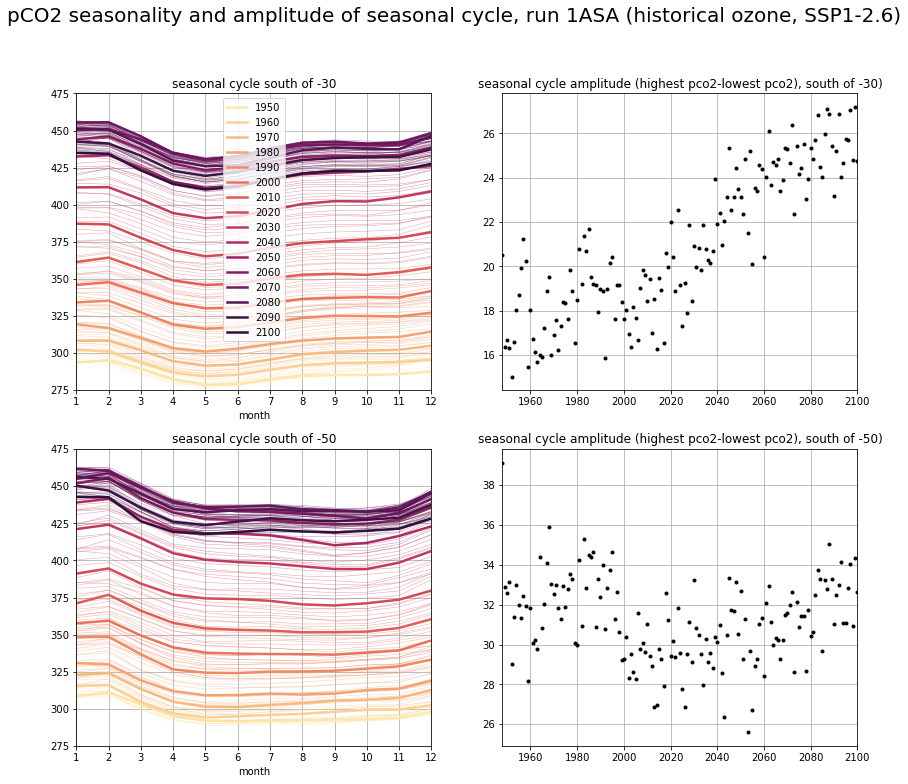

In [7]:
yrs = np.arange(1948,2101,1)
mos = np.arange(1,13,1)

# for i in range(0,153):
#     plt.plot(mos, stor_pco2[i,:,0])
    
tcm = cm.matter
fig, axs = plt.subplots(2,2, figsize=(14, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()


for i in range(0,153):

    axs[0].plot(mos, stor_pco2[i,:,0], color = tcm(1.*(i)/150), linewidth = 0.5, alpha = 0.5)
    if yrs[i]%10 == 0:
        axs[0].plot(mos, stor_pco2[i,:,0], color = tcm(1.*(i)/150), linewidth = 2.5, label = yrs[i])
    axs[1].plot(yrs[i],np.nanmax(stor_pco2[i,:,0])-np.nanmin(stor_pco2[i,:,0]),'k.')
        
    axs[2].plot(mos, stor_pco2[i,:,1], color = tcm(1.*(i)/150), linewidth = 0.5, alpha = 0.5)
    if yrs[i]%10 == 0:
        axs[2].plot(mos, stor_pco2[i,:,1], color = tcm(1.*(i)/150), linewidth = 2.5, label = yrs[i])
    axs[3].plot(yrs[i],np.nanmax(stor_pco2[i,:,1])-np.nanmin(stor_pco2[i,:,0]),'k.')
 
for i in [0,2]:
    axs[i].set_xticks(np.arange(1,13,1))
    axs[i].set_xlim([1,12])
    axs[i].set_xlabel('month')
    axs[i].set_ylim([275,475])
for i in [1,3]:
    axs[i].set_xlim([1948,2100])

axs[0].legend(loc = 'best')

tits = ['seasonal cycle south of -30', 'seasonal cycle amplitude (highest pco2-lowest pco2), south of -30)',\
'seasonal cycle south of -50', 'seasonal cycle amplitude (highest pco2-lowest pco2), south of -50)']

plt.suptitle('pCO2 seasonality and amplitude of seasonal cycle, run 1ASA (historical ozone, SSP1-2.6)', fontsize = 20)

for i in range(0,4):
    axs[i].set_title(tits[i])
    axs[i].grid()

## extract planktom11, RW_t201


In [8]:



def extract_ts_2d(ftype, vartype, dsets, exhorse = False, \
                  yst = 1948, yend = 2100, note = 'I didnt fill this out'):
    

    tdir = '/gpfs/home/mep22dku/scratch/SOZONE/MO_RESULTS/EXTRACT/ncs/'
    print(f'{ftype}, {vartype}')

    if exhorse:
        print(dsets)
        for d in dsets:
            fn = f'{tdir}/{d}_{vartype}_{yst}_{yend}.nc'
            print(f'making {fn}')
    
            ylist = ut.make_yearlist(yst,yend,ftype,d)
            with xr.set_options(enable_cftimeindex=True):
                TJ_1ASA = xr.open_mfdataset(ylist)
            TJ_1ASA['time_counter'] = TJ_1ASA.indexes['time_counter'].to_datetimeindex()
            #extract the relevant
            nav_lat = TJ_1ASA['nav_lat'][:,0].values
            nav_lon = TJ_1ASA['nav_lon'][0,:].values
            time_counter = TJ_1ASA['time_counter'].values
            Cflx = TJ_1ASA[vartype].values

            # define data with variable attributes
            print(vartype)
            data_vars = {vartype:(['time_counter','nav_lat','nav_lon'], Cflx, 
                                     {'units': '', 
                                      'long_name':''})}

            # define coordinates
            coords = {'time_counter': (['time_counter'], time_counter),\
                     'nav_lat': (['nav_lat'], nav_lat),\
                     'nav_lon': (['nav_lon'], nav_lon)}

            # define global attributes
            attrs = {'author':'TJSJ', 
                     'notes': note}

            # create dataset
            ds = xr.Dataset(data_vars=data_vars, 
                            coords=coords, 
                            attrs=attrs)
        
            ds.to_netcdf(fn)
            print('done')
            
# dsets = ['TOM11_RW_t201']
# extract_ts_2d('dia2d_T', 'dpco2', dsets, exhorse = True, \
#                   yst = 2000, yend = 2017, note = 'I didnt fill this out')
# dsets = ['TOM12_TJ_1ASA', 'TOM12_DW_WE43', 'TOM12_DW_GA01']
# extract_ts_2d('diad_T', 'dpCO2', dsets, exhorse = True, \
#                   yst = 2000, yend = 2017, note = 'I didnt fill this out')
# dsets = ['TOM12_TJ_1ASA', 'TOM12_DW_WE43', 'TOM12_DW_GA01']
# extract_ts_2d('diad_T', 'pCO2', dsets, exhorse = False, \
#                   yst = 2000, yend = 2017, note = 'I didnt fill this out')

In [9]:
TJ_1ASA_pCO2 = xr.open_dataset('/gpfs/home/mep22dku/scratch/SOZONE/MO_RESULTS/EXTRACT/ncs//TOM12_TJ_1ASA_pCO2_2000_2017.nc')
DW_WE43_pCO2 = xr.open_dataset('/gpfs/home/mep22dku/scratch/SOZONE/MO_RESULTS/EXTRACT/ncs//TOM12_DW_WE43_pCO2_2000_2017.nc')
DW_GA01_pCO2 = xr.open_dataset('/gpfs/home/mep22dku/scratch/SOZONE/MO_RESULTS/EXTRACT/ncs//TOM12_DW_GA01_pCO2_2000_2017.nc')

TJ_1ASA_dpCO2 = xr.open_dataset('/gpfs/home/mep22dku/scratch/SOZONE/MO_RESULTS/EXTRACT/ncs//TOM12_TJ_1ASA_dpCO2_2000_2017.nc')
DW_WE43_dpCO2 = xr.open_dataset('/gpfs/home/mep22dku/scratch/SOZONE/MO_RESULTS/EXTRACT/ncs//TOM12_DW_WE43_dpCO2_2000_2017.nc')
DW_GA01_dpCO2 = xr.open_dataset('/gpfs/home/mep22dku/scratch/SOZONE/MO_RESULTS/EXTRACT/ncs//TOM12_DW_GA01_dpCO2_2000_2017.nc')
RW_t201_dpCO2 = xr.open_dataset('/gpfs/home/mep22dku/scratch/SOZONE/MO_RESULTS/EXTRACT/ncs//TOM11_RW_t201_dpco2_2000_2017.nc')


In [10]:
q = TJ_1ASA_pCO2['pCO2'].values
TJ_1ASA_pCO2_yrstor = np.zeros([18, 12, 149, 182])
count = 0
for i in range(0,18):
    TJ_1ASA_pCO2_yrstor[i,:,:,:] = q[count:count+12,:,:]
    count = count+12
    
q = DW_WE43_pCO2['pCO2'].values
DW_WE43_pCO2_yrstor = np.zeros([18, 12, 149, 182])
count = 0
for i in range(0,18):
    DW_WE43_pCO2_yrstor[i,:,:,:] = q[count:count+12,:,:]
    count = count+12
    
q = DW_GA01_pCO2['pCO2'].values
DW_GA01_pCO2_yrstor = np.zeros([18, 12, 149, 182])
count = 0
for i in range(0,18):
    DW_GA01_pCO2_yrstor[i,:,:,:] = q[count:count+12,:,:]
    count = count+12
    
q = TJ_1ASA_dpCO2['dpCO2'].values
TJ_1ASA_dpCO2_yrstor = np.zeros([18, 12, 149, 182])
count = 0
for i in range(0,18):
    TJ_1ASA_dpCO2_yrstor[i,:,:,:] = q[count:count+12,:,:]
    count = count+12
    
q = DW_WE43_dpCO2['dpCO2'].values
DW_WE43_dpCO2_yrstor = np.zeros([18, 12, 149, 182])
count = 0
for i in range(0,18):
    DW_WE43_dpCO2_yrstor[i,:,:,:] = q[count:count+12,:,:]
    count = count+12
    
q = DW_GA01_dpCO2['dpCO2'].values
DW_GA01_dpCO2_yrstor = np.zeros([18, 12, 149, 182])
count = 0
for i in range(0,18):
    DW_GA01_dpCO2_yrstor[i,:,:,:] = q[count:count+12,:,:]
    count = count+12
    
q = RW_t201_dpCO2['dpco2'].values
RW_t201_dpCO2_yrstor = np.zeros([18, 12, 149, 182])
count = 0
for i in range(0,18):
    RW_t201_dpCO2_yrstor[i,:,:,:] = q[count:count+12,:,:]
    count = count+12

In [16]:
DW_WE43_pCO2_mean = np.zeros([3,12])

thisone_30 = np.nanmean(DW_WE43_pCO2_yrstor[:,:,0:50,:], axis = 0)
thisone_50 = np.nanmean(DW_WE43_pCO2_yrstor[:,:,0:37,:], axis = 0)
thisone_3050 = np.nanmean(DW_WE43_pCO2_yrstor[:,:,37:50,:], axis = 0)

tweights_30 = so_csize_broad[0,0:50,:]
tweights_50 = so_csize_broad[0,0:37,:]
tweights_3050 = so_csize_broad[0,37:50,:]

for i in range(0,12):
    DW_WE43_pCO2_mean[0,i] = np.average(thisone_30[i,:,:], weights = tweights_30)
    DW_WE43_pCO2_mean[1,i] = np.average(thisone_50[i,:,:], weights = tweights_50)
    DW_WE43_pCO2_mean[2,i] = np.average(thisone_3050[i,:,:], weights = tweights_3050)
  

TJ_1ASA_pCO2_mean = np.zeros([3,12])

thisone_30 = np.nanmean(TJ_1ASA_pCO2_yrstor[:,:,0:50,:], axis = 0)
thisone_50 = np.nanmean(TJ_1ASA_pCO2_yrstor[:,:,0:37,:], axis = 0)
thisone_3050 = np.nanmean(TJ_1ASA_pCO2_yrstor[:,:,37:50,:], axis = 0)

tweights_30 = so_csize_broad[0,0:50,:]
tweights_50 = so_csize_broad[0,0:37,:]
tweights_3050 = so_csize_broad[0,37:50,:]

for i in range(0,12):
    TJ_1ASA_pCO2_mean[0,i] = np.average(thisone_30[i,:,:], weights = tweights_30)
    TJ_1ASA_pCO2_mean[1,i] = np.average(thisone_50[i,:,:], weights = tweights_50)
    TJ_1ASA_pCO2_mean[2,i] = np.average(thisone_3050[i,:,:], weights = tweights_3050)

DW_GA01_pCO2_mean = np.zeros([3,12])

thisone_30 = np.nanmean(DW_GA01_pCO2_yrstor[:,:,0:50,:], axis = 0)
thisone_50 = np.nanmean(DW_GA01_pCO2_yrstor[:,:,0:37,:], axis = 0)
thisone_3050 = np.nanmean(DW_GA01_pCO2_yrstor[:,:,37:50,:], axis = 0)

tweights_30 = so_csize_broad[0,0:50,:]
tweights_50 = so_csize_broad[0,0:37,:]

for i in range(0,12):
    DW_GA01_pCO2_mean[0,i] = np.average(thisone_30[i,:,:], weights = tweights_30)
    DW_GA01_pCO2_mean[1,i] = np.average(thisone_50[i,:,:], weights = tweights_50)
    DW_GA01_pCO2_mean[2,i] = np.average(thisone_3050[i,:,:], weights = tweights_3050)
  

In [19]:
DW_WE43_dpCO2_mean = np.zeros([3,12])

thisone_30 = np.nanmean(DW_WE43_dpCO2_yrstor[:,:,0:50,:], axis = 0)
thisone_50 = np.nanmean(DW_WE43_dpCO2_yrstor[:,:,0:37,:], axis = 0)
thisone_3050 = np.nanmean(DW_WE43_dpCO2_yrstor[:,:,37:50,:], axis = 0)

tweights_30 = so_csize_broad[0,0:50,:]
tweights_50 = so_csize_broad[0,0:37,:]
tweights_3050 = so_csize_broad[0,37:50,:]

for i in range(0,12):
    DW_WE43_dpCO2_mean[0,i] = np.average(thisone_30[i,:,:], weights = tweights_30)
    DW_WE43_dpCO2_mean[1,i] = np.average(thisone_50[i,:,:], weights = tweights_50)
    DW_WE43_dpCO2_mean[2,i] = np.average(thisone_3050[i,:,:], weights = tweights_3050)
  

TJ_1ASA_dpCO2_mean = np.zeros([3,12])

thisone_30 = np.nanmean(TJ_1ASA_dpCO2_yrstor[:,:,0:50,:], axis = 0)
thisone_50 = np.nanmean(TJ_1ASA_dpCO2_yrstor[:,:,0:37,:], axis = 0)
thisone_3050 = np.nanmean(TJ_1ASA_dpCO2_yrstor[:,:,37:50,:], axis = 0)

tweights_30 = so_csize_broad[0,0:50,:]
tweights_50 = so_csize_broad[0,0:37,:]
tweights_3050 = so_csize_broad[0,37:50,:]

for i in range(0,12):
    TJ_1ASA_dpCO2_mean[0,i] = np.average(thisone_30[i,:,:], weights = tweights_30)
    TJ_1ASA_dpCO2_mean[1,i] = np.average(thisone_50[i,:,:], weights = tweights_50)
    TJ_1ASA_dpCO2_mean[2,i] = np.average(thisone_3050[i,:,:], weights = tweights_3050)

DW_GA01_dpCO2_mean = np.zeros([3,12])

thisone_30 = np.nanmean(DW_GA01_dpCO2_yrstor[:,:,0:50,:], axis = 0)
thisone_50 = np.nanmean(DW_GA01_dpCO2_yrstor[:,:,0:37,:], axis = 0)
thisone_3050 = np.nanmean(DW_GA01_dpCO2_yrstor[:,:,37:50,:], axis = 0)

tweights_30 = so_csize_broad[0,0:50,:]
tweights_50 = so_csize_broad[0,0:37,:]

for i in range(0,12):
    DW_GA01_dpCO2_mean[0,i] = np.average(thisone_30[i,:,:], weights = tweights_30)
    DW_GA01_dpCO2_mean[1,i] = np.average(thisone_50[i,:,:], weights = tweights_50)
    DW_GA01_dpCO2_mean[2,i] = np.average(thisone_3050[i,:,:], weights = tweights_3050)



In [22]:


RW_t201_dpCO2_mean = np.zeros([3,12])

thisone_30 = np.nanmean(RW_t201_dpCO2_yrstor[:,:,0:50,:], axis = 0)
thisone_50 = np.nanmean(RW_t201_dpCO2_yrstor[:,:,0:37,:], axis = 0)
thisone_3050 = np.nanmean(RW_t201_dpCO2_yrstor[:,:,37:50,:], axis = 0)

tweights_30 = so_csize_broad[0,0:50,:]
tweights_50 = so_csize_broad[0,0:37,:]
tweights_3050 = so_csize_broad[0,37:50,:]

for i in range(0,12):
    fxnl = np.where(~np.isnan(thisone_30[i,:,:]))
    t_30 = thisone_30[i,:,:]
    fxnl2 = np.where(~np.isnan(thisone_50[i,:,:]))
    t_50 = thisone_50[i,:,:]
    fxnl3 = np.where(~np.isnan(thisone_3050[i,:,:]))
    t_3050 = thisone_3050[i,:,:]
    
    RW_t201_dpCO2_mean[0,i] = np.average(t_30[fxnl], weights = tweights_30[fxnl])
    # RW_t201_dpCO2_mean[1,i] = np.average(thisone_50[i,:,:], weights = tweights_50)
    RW_t201_dpCO2_mean[1,i] = np.average(t_50[fxnl2], weights = tweights_50[fxnl2])
    RW_t201_dpCO2_mean[2,i] = np.average(t_3050[fxnl3], weights = tweights_3050[fxnl3])
    # RW_t201_dpCO2_mean[1,i] = np.average(thisone_50[i,:,:], weights = tweights_50)

In [23]:
RW_t201_dpCO2_mean

array([[381.22939157, 382.81124354, 375.18343848, 364.78029934,
        357.14862188, 353.20100853, 351.54324666, 350.87347323,
        350.82782566, 352.22002833, 358.33661966, 370.85187097],
       [381.11780507, 383.82436261, 375.95940239, 364.80950793,
        355.70367697, 349.30839501, 344.83231688, 342.08191148,
        341.26299382, 342.96219374, 349.90676877, 365.80207359],
       [381.31403651, 382.04273306, 374.59482416, 364.75814291,
        358.24469768, 356.15378509, 356.63388204, 357.54239048,
        358.0833138 , 359.24264099, 364.73115793, 374.68243962]])

Text(0.5, 0.98, 'average of year 2000-2017, pCO2 and dPCO2, area-weighted, monthly')

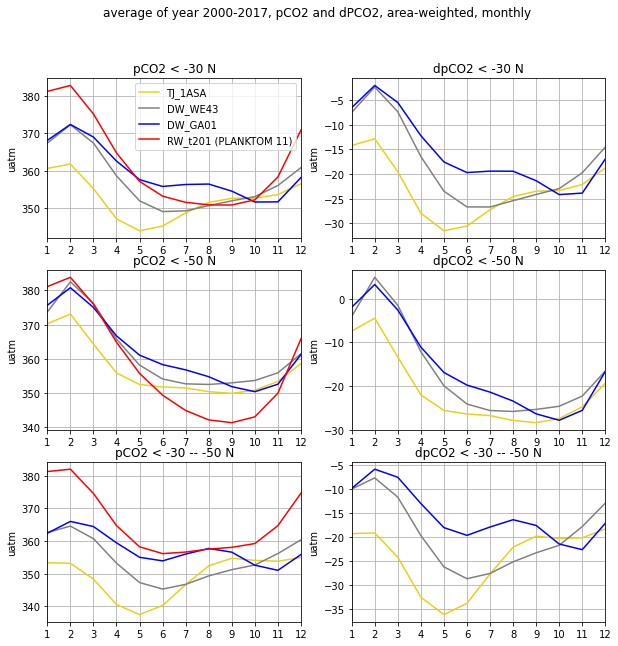

In [26]:
tcm = cm.matter
fig, axs = plt.subplots(3,2, figsize=(10, 10), facecolor='w', edgecolor='k')
axs = axs.ravel()

pco2s = [TJ_1ASA_pCO2_mean,DW_WE43_pCO2_mean,DW_GA01_pCO2_mean,RW_t201_dpCO2_mean]
dpco2s = [TJ_1ASA_dpCO2_mean,DW_WE43_dpCO2_mean,DW_GA01_dpCO2_mean]
labels = ['TJ_1ASA','DW_WE43','DW_GA01','RW_t201 (PLANKTOM 11)']
colors = [sc.scen['1A']['color'],'grey','blue','r']
for i in range(0,4):
    axs[0].plot(np.arange(1,13,1), pco2s[i][0,:], color = colors[i], label = labels[i])
    axs[2].plot(np.arange(1,13,1), pco2s[i][1,:], color = colors[i])
    axs[4].plot(np.arange(1,13,1), pco2s[i][2,:], color = colors[i])
for i in range(0,3):
    axs[1].plot(np.arange(1,13,1), dpco2s[i][0,:], color = colors[i])
    axs[3].plot(np.arange(1,13,1), dpco2s[i][1,:], color = colors[i])
    axs[5].plot(np.arange(1,13,1), dpco2s[i][2,:], color = colors[i])
    
tits = ['pCO2 < -30 N', 'dpCO2 < -30 N', 'pCO2 < -50 N', 'dpCO2 < -50 N', 'pCO2 < -30 -- -50 N', 'dpCO2 < -30 -- -50 N']
for i in range(0,6):
    axs[i].grid()
    axs[i].set_title(tits[i])
    axs[i].set_xticks(np.arange(1,13,1))
    axs[i].set_xlim([1,12])
    axs[i].set_ylabel('uatm')
axs[0].legend()

plt.suptitle('average of year 2000-2017, pCO2 and dPCO2, area-weighted, monthly')

In [27]:
print('done')

done
